In [ ]:
import scipy
import sklearn
import elpigraph
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import stream2 as st2
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def get_tp(gene_list,vars_bool):
    ''' Return % of true positives '''
    tp_score = []
    perc_detected = []
    for i,n in enumerate(vars_bool.index):
        if n in gene_list: 
            vars_bool[n] = True
        perc_detected.append(sum(vars_bool[:n])/len(gene_list))
        tp_score.append(sum(vars_bool[:n])/(i+1))
    return perc_detected, tp_score

def plot_tp(fname,gene_list,vars_bools):
    ''' Plot true positives '''
    plt.rcParams.update({'font.size': 15})
    fig, axs = plt.subplots(3,1,figsize=(5,10),sharex=True,constrained_layout=True)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i in range(3):
        ax1 = axs[i]
        perc_detected, tp_score = get_tp(gene_list,vars_bools[i])

        ax1.plot(perc_detected,label='Fraction of markers found',c=colors[1])
        ylim=ax1.get_ylim()
        ax1.plot(tp_score,label='True positives / Total tested',c=colors[0])
        ax1.set_ylim(ylim)
        
        ax2 = ax1.twinx()
        ax2.plot(np.array(perc_detected)*len(gene_list),alpha=0,c=colors[0])

        if i==0: ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4))
        if i==2: ax1.set_xlabel('Markers rank',fontsize=20)
            
        ax2.set_ylabel('Number',fontsize=20,rotation=270,labelpad=20)
        ax1.set_ylabel('Fraction',fontsize=20)
        ax1.xaxis.set_minor_locator(MultipleLocator(100))

    plt.tight_layout()
    plt.savefig(fname,dpi=300,bbox_inches="tight")
    plt.show()

# Load data
We directly load preprocessed data. 
Uncomment the cell below if you wish to replicate preprocessing yourself

In [2]:
data_path='../data/ewing.h5ad'
adata=sc.read(data_path)

In [3]:
#data_path = '/mnt/c/Users/jobac/Desktop/all/STREAM2/data/ewing/'
#X_ica = pd.read_csv(data_path+'moduleAverages/pdx352_nufp2k.txt.moduleAverages',sep='\t').iloc[:,1:21]
#X_full = pd.read_csv(data_path+'pdx352_nufp.txt',sep='\t').T
#X_full.rename(columns=X_full.iloc[0],inplace=True)
#X_full.drop(X_full.index[0],inplace=True)
#X_full.drop(columns=np.nan,axis=1,inplace=True)
#
#adata=sc.AnnData(X_full)
#adata.obs['oncogene']=adata[:,'EWSR1'].X
#
#scv.pp.filter_genes(adata, min_counts=20)
#scv.pp.normalize_per_cell(adata,enforce=True)
#scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
#sc.pp.pca(adata)
#
#adata.obsm['X_dr']=X_ica[['IC1+','IC2+','IC10+']].values
#adata.obsm['X_ica']=X_ica.values
#adata.write('../data/ewing.h5ad')

# Default trajectories

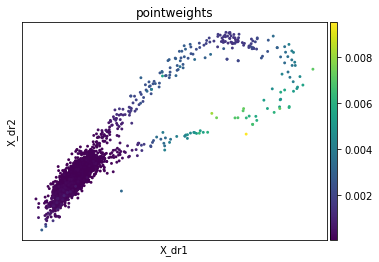

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...
Constructing tree 1 of 1 / Subset 1 of 1
Computing EPG with  50  nodes on  3595  points and  3  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||11	0.0128	11	10	7	1	0	0	0.0065	0.0048	0.8997	0.9263	0.0036	0.0026	0.0289	0.3174	0
1||12	0.0136	12	11	8	1	0	0	0.0078	0.0056	0.8804	0.9137	0.0036	0.0022	0.026	0.3126	0
1||13	0.0125	13	12	9	1	0	0	0.007	0.0052	0.892	0.9204	0.0036	0.0018	0.0238	0.3098	0
1||14	0.0112	14	13	10	1	0	0	0.0058	0.0043	0.9107	0.9337	0.0035	0.0019	0.0268	0.3749	0
1||15	0.0116	15	14	11	1	0	0	0.0066	0.0048	0.8983	0.926	0.0034	0.0016	0.0237	0.3549	0
1||16	0.0103	16	15	12	1	0	0	0.0054	0.004	0.9167	0.9385	0.0035	0.0014	0.0219	0.3511	0
1||17	0.0099	17	16	13	1	0	0	0.0055	0.0041	0.9149	0.9373	0.0033	0.001	0.0177	0.3014	0
1||18	0.0095	18	17	14	1	0	0	0.0055	0.0041	0.915	0.9371	0.0031	0.0008	0.0151	0.2714	0
1||19	0.0085	19	18	15

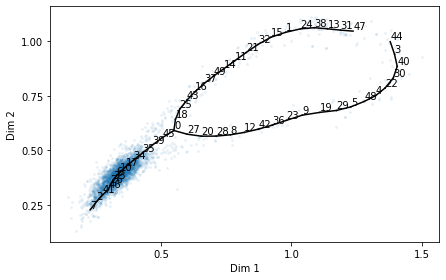

In [4]:
st2.tl.get_weights(adata,exponent=1,bandwidth=.1)
sc.pl.embedding(adata,'X_dr',color='pointweights')
st2.tl.seed_graph(adata,use_weights=True)
st2.tl.learn_graph(adata,n_nodes=50,use_weights=True,verbose=1)
st2.pl.graph(adata,show_text=1,alpha=.1,)

Searching potential loops...
Using default parameters: max_n_points=179, radius=0.28, min_node_n_points=1, min_path_len=10, nnodes=6
testing 7 candidates
Suggested paths:
  source node  target node  inner fraction     MSE  n° of points in path
           47           44          0.0391  0.0027                   276
Performing simulated annealing. This may take a while
(1, 3)
(54, 3)


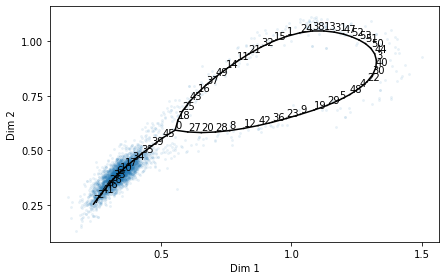

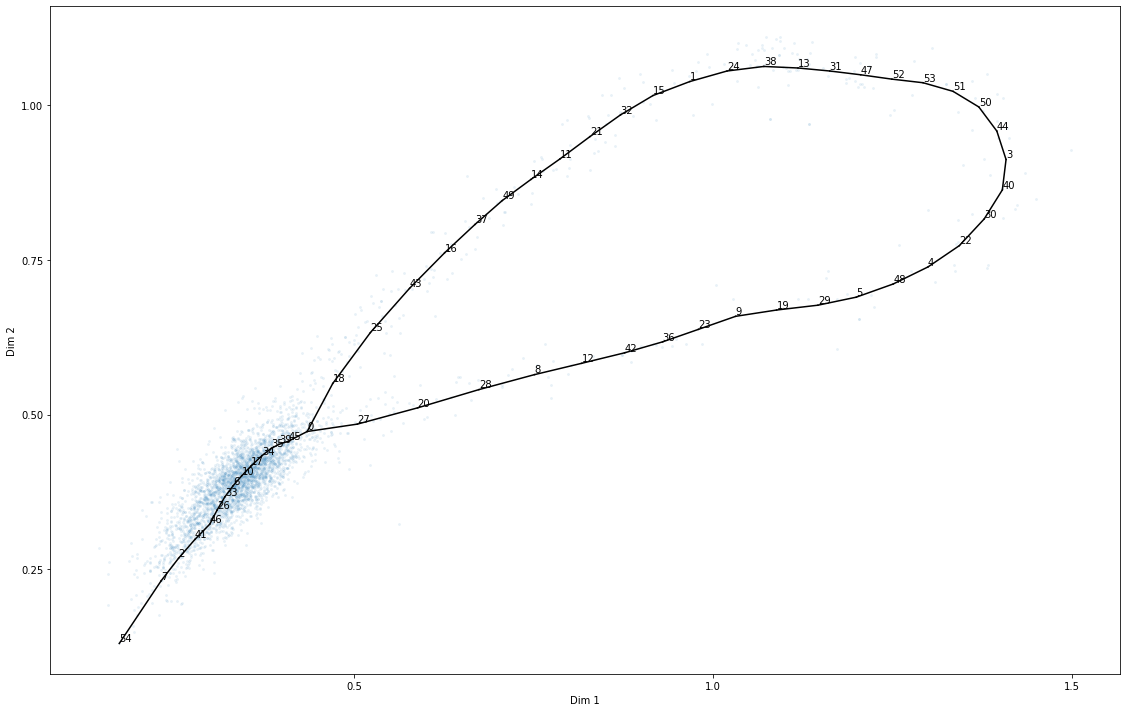

In [6]:
st2.tl.find_paths(adata,min_node_n_points=1,verbose=1,inplace=True)
st2.pl.graph(adata,show_text=1,alpha=.1)
st2.tl.refit_graph(adata,shift_nodes_pos={0:adata.uns['epg']['node_pos'][0]+[-.12,-.12,0.05]},use_weights=True)
st2.tl.extend_leaves(adata,Mode='QuantDists',ControlPar=.5)
st2.pl.graph(adata,show_text=1,alpha=.1,fig_size=(15,10))

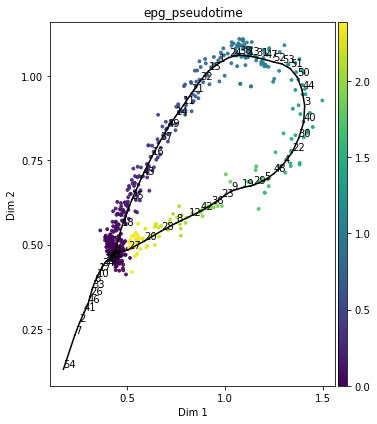

In [7]:
st2.tl.infer_pseudotime(adata,0,27,nodes_to_include=[18])
st2.pl.graph(adata,show_text=1,fig_size=(5,6),color=['epg_pseudotime'])

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


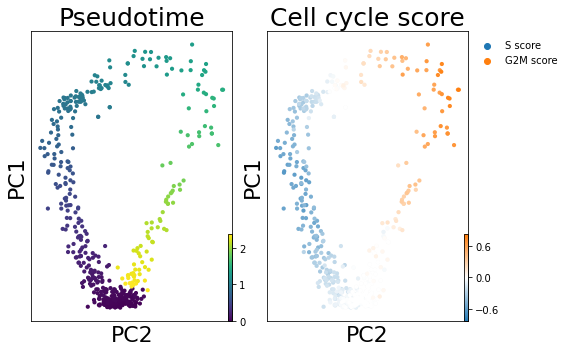

In [8]:
scv.tl.score_genes_cell_cycle(adata)

_adata = adata[np.isfinite(adata.obs['epg_pseudotime'])].copy()
_adata.obsm['X_pca'] = Xpca = sklearn.decomposition.PCA(2).fit_transform(_adata.obsm['X_dr'])[:,::-1]

f,axs=plt.subplots(1,2,figsize=(8,5),sharex=True,sharey=True)
scv.pl.scatter(_adata, basis='X_pca',color='epg_pseudotime', smooth=False, #perc=[5, 95],
               colorbar=True,frameon=1, size=70,alpha=1,dpi=300,ax=axs[0],show=False)

scv.pl.scatter(_adata, basis='X_pca',color_gradients=['S_score', 'G2M_score'], smooth=False, #perc=[5, 95],
               colorbar=True,frameon=1, size=70,alpha=1,dpi=300,ax=axs[1],show=False)
ax=axs[0]
ax.set_xlabel("PC2",fontsize=22)
ax.set_ylabel("PC1",fontsize=22)
ax.set_xticks([])
ax.set_yticks([])
#ax.locator_params(axis="x", nbins=5)
#ax.locator_params(axis="y", nbins=5)
#ax.tick_params(axis="both", labelbottom=True, labelleft=True)
ax.set_title('Pseudotime',fontsize=25)

ax=axs[1]
ax.set_xlabel("PC2",fontsize=22)
ax.set_ylabel("PC1",fontsize=22)
ax.set_title('Cell cycle score',fontsize=25)

plt.tight_layout()
plt.savefig("figures/ewing_cycle_scatter.png",dpi=300,bbox_inches='tight')
plt.show()

Calculating MAGIC...
  Running MAGIC on 509 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 0.50 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 0.54 seconds.
509 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_0-[18]-27
Filtering out markers that are expressed in less than 5 cells ...
1434 markers are being scanned ...
509 Cells are selected for Path_Source_Nodes-to-include_Target :  Path_0-[18]-27
Filtering out markers that are expressed in less than 5 cells ...


Trying to set attribute `.uns` of view, copying.


1434 markers are being scanned ...


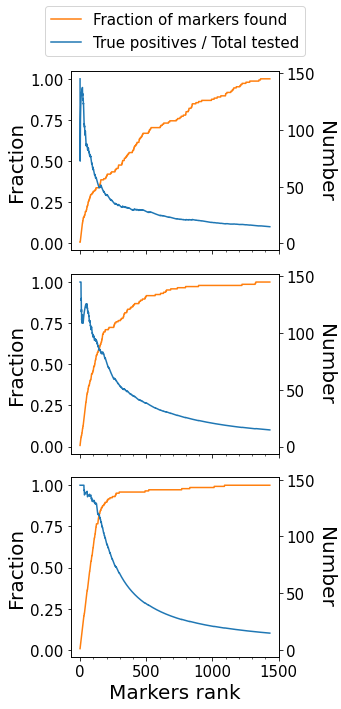

In [9]:
#----- get cycle data, cycle genes that are expressed 
_adata=adata[np.isfinite(adata.obs['epg_pseudotime'])].copy()
_adata.var_names=adata.var_names.map(lambda s:s.upper())
sc.external.pp.magic(_adata,verbose=1)

cc_genes = ['ACYP1', 'ALG6', 'ANKRD32', 'ANLN', 'ANP32E', 'APEX2', 'APOBEC3B','ARHGAP11A', 'ARHGAP11B', 'ARHGAP19', 'ARHGEF39', 'ARL6IP1','ARL6IP6', 'ASF1B', 'ASPM', 'ATAD2', 'ATAD5', 'AURKA', 'AURKB','BARD1', 'BIRC5', 'BLM', 'BORA', 'BRCA1', 'BRCA2', 'BRD8', 'BRIP1','BUB1', 'BUB1B', 'BUB3', 'C11orf82', 'C15orf23', 'C18orf54','C19orf48', 'C1orf112', 'C20orf72', 'C3orf14', 'C4orf21','C4orf46', 'CASC5', 'CASP2', 'CASP8AP2', 'CCDC14', 'CCDC15','CCDC150', 'CCDC18', 'CCDC34', 'CCDC77', 'CCNA2', 'CCNB1', 'CCNB2','CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2', 'CCNF', 'CCNH','CCP110', 'CDC20', 'CDC25A', 'CDC25B', 'CDC25C', 'CDC45', 'CDC6','CDC7', 'CDCA2', 'CDCA3', 'CDCA4', 'CDCA5', 'CDCA7', 'CDCA7L','CDCA8', 'CDK1', 'CDK2', 'CDK4', 'CDK5RAP2', 'CDK6', 'CDK7','CDKN1A', 'CDKN1B', 'CDKN1C', 'CDKN2A', 'CDKN2B', 'CDKN2C','CDKN2D', 'CDKN3', 'CENPA', 'CENPE', 'CENPF', 'CENPI', 'CENPJ','CENPK', 'CENPL', 'CENPM', 'CENPN', 'CENPO', 'CENPQ', 'CEP128','CEP152', 'CEP44', 'CEP55', 'CEP70', 'CEP78', 'CHAC2', 'CHAF1A','CHAF1B', 'CHEK1', 'CIT', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B','CKS2', 'CLSPN', 'CNTRL', 'CSE1L', 'CSRP2', 'CTD-2510F5.4','CTDSPL2', 'CTPS1', 'DARS2', 'DAXX', 'DBF4', 'DCK', 'DCLRE1B','DCP2', 'DCTPP1', 'DDB2', 'DDX11', 'DDX12P', 'DDX39A', 'DEK','DEPDC1', 'DEPDC1B', 'DERA', 'DHCR24', 'DHFR', 'DIAPH3', 'DLGAP5','DNA2', 'DNAJC9', 'DNMT1', 'DONSON', 'DSN1', 'DTL', 'DTYMK', 'DUT','E2F1', 'E2F2', 'E2F4', 'E2F5', 'E2F7', 'ECT2', 'EED', 'EMC9','EME1', 'ENOSF1', 'ERCC6L', 'ERLIN1', 'ESCO2', 'ESPL1', 'EXO1','EXOSC8', 'EXOSC9', 'EZH2', 'FAM111A', 'FAM111B', 'FAM122B','FAM161A', 'FAM178A', 'FAM54A', 'FAM64A', 'FAM72D', 'FAM83D','FANCA', 'FANCB', 'FANCD2', 'FANCI', 'FANCL', 'FBXO4', 'FBXO5','FEN1', 'FGFR1OP', 'FIGNL1', 'FKBP5', 'FN3KRP', 'FOXM1', 'FOXRED2','G2E3', 'GAS2L3', 'GEN1', 'GGCT', 'GGH', 'GINS1', 'GINS2', 'GINS3','GINS4', 'GJC1', 'GMNN', 'GOT1', 'GPSM2', 'GTSE1', 'H2AFV','H2AFX', 'H2AFZ', 'HADH', 'HAT1', 'HAUS1', 'HAUS5', 'HAUS6','HAUS8', 'HELLS', 'HIRIP3', 'HIST1H1B', 'HIST1H4C', 'HJURP','HMGB2', 'HMGB3', 'HMGN2', 'HMGXB4', 'HMMR', 'HNRNPF', 'HPRT1','HSD17B11', 'HSPB11', 'INCENP', 'INSR', 'IQGAP3', 'ITGB3BP','IVNS1ABP', 'KDELC2', 'KIAA0101', 'KIAA0586', 'KIAA1524','KIAA1731', 'KIF11', 'KIF14', 'KIF15', 'KIF18A', 'KIF18B','KIF20A', 'KIF20B', 'KIF22', 'KIF23', 'KIF2C', 'KIF4A', 'KIFC1','KNTC1', 'KPNA2', 'LIG1', 'LIN9', 'LRR1', 'MAD2L1', 'MASTL','MBOAT1', 'MCM10', 'MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7','MCM8', 'MCMBP', 'MDM1', 'MELK', 'MIS18A', 'MIS18BP1', 'MKI67','MLF1IP', 'MMS22L', 'MNAT1', 'MND1', 'MNS1', 'MPHOSPH9', 'MRE11A','MSH2', 'MSH6', 'MTBP', 'MTHFD1', 'MYBL2', 'MYO19', 'MZT1', 'NASP','NCAPD2', 'NCAPD3', 'NCAPG', 'NCAPG2', 'NCAPH', 'NDC80', 'NDE1','NEDD1', 'NEIL3', 'NEK2', 'NETO2', 'NPAT', 'NR2C2AP', 'NRM','NUDT1', 'NUF2', 'NUP107', 'NUP155', 'NUP205', 'NUP35', 'NUP62','NUP85', 'NUSAP1', 'ODF2', 'OGN', 'OIP5', 'OMD', 'ORC1', 'ORC6','PARP1', 'PARP2', 'PARPBP', 'PAX6', 'PBK', 'PCNA', 'PDLIM3','PHF19', 'PHGDH', 'PHIP', 'PHTF2', 'PIF1', 'PKNOX1', 'PLK1','PLK4', 'PLSCR1', 'PMS1', 'POC1A', 'POLA1', 'POLA2', 'POLD3','POLE', 'POLE2', 'POLQ', 'POLR3K', 'PRC1', 'PRIM1', 'PRIM2','PRPF4', 'PRPS2', 'PRR11', 'PSIP1', 'PSMC3IP', 'PSRC1', 'PTTG1','RACGAP1', 'RAD1', 'RAD18', 'RAD21', 'RAD51', 'RAD51AP1', 'RAD51C','RAD54L', 'RANGAP1', 'RB1', 'RBBP8', 'RBL1', 'RECQL', 'RFC2','RFC3', 'RFC4', 'RFC5', 'RFWD3', 'RHNO1', 'RMI1', 'RMI2','RNASEH2A', 'RNF26', 'RP11-303E16.2', 'RPA1', 'RPA2', 'RPA3','RRM1', 'RRM2', 'RTKN2', 'SAPCD2', 'SASS6', 'SCLT1', 'SFI1','SGOL1', 'SGOL2', 'SHCBP1', 'SHMT1', 'SKA1', 'SKA2', 'SKA3','SKP2', 'SLBP', 'SLC20A1', 'SLC29A1', 'SLC43A3', 'SMC1A', 'SMC2','SMC4', 'SNHG1', 'SPAG5', 'SPC24', 'SPC25', 'SPDL1', 'SRSF2','STIL', 'STRA13', 'SYNE2', 'TACC3', 'TCF19', 'TDP1', 'TEX30','TFDP1', 'TIMELESS', 'TIMM21', 'TIPIN', 'TK1', 'TMEM106C','TMEM116', 'TMEM19', 'TMEM194A', 'TMEM38B', 'TMEM48', 'TMEM97','TMPO', 'TOP2A', 'TOP3A', 'TOPBP1', 'TPX2', 'TRAIP', 'TREX1','TRIM45', 'TRIP13', 'TROAP', 'TTF2', 'TTI1', 'TTK', 'TUBA1C','TUBB4B', 'TUBB6', 'TUBG1', 'TYMS', 'UBE2C', 'UBE2T', 'UBR7','UHRF1', 'UNG', 'USP1', 'USP37', 'VRK1', 'VSIG10', 'WDHD1','WDR76', 'WDYHV1', 'WEE1', 'WHSC1', 'XRCC2', 'YEATS4', 'ZMYM1','ZNF107', 'ZNF367', 'ZNF519', 'ZNF738', 'ZNF93', 'ZWILCH', 'ZWINT','DSCC1', 'E2F8', 'HN1', 'LBR', 'CTCF', 'CBX5', 'ADAMTS1', 'C17orf75', 'C9orf40', 'CACYBP', 'CDT1', 'CENPU','CEP57', 'CREBZF', 'CRYL1', 'DSCC1', 'E2F8', 'EFCAB11', 'ENDOD1','ETAA1', 'EYA2', 'FANCE', 'FANCG', 'GLMN', 'GMPS', 'GPD2', 'HSF2','METTL9', 'MMD', 'MPP1', 'NSMCE4A', 'OSGEPL1', 'PAK1', 'PAQR4','PASK', 'PAXIP1', 'PBX3', 'PKMYT1', 'RAB23', 'RDX', 'SLC25A40','SMC3', 'SSX2IP', 'SUPT16H', 'THAP10', 'THEM6', 'TSPYL4','TUBGCP5', 'WRB', 'ZBTB14', 'ADGRE5', 'ARHGDIB', 'CDC27', 'CEP85', 'CTCF', 'DBF4B', 'DCAF7','FZD2', 'FZD7', 'FZR1', 'GTF2E1', 'HN1', 'JADE2', 'KIF5B', 'LBR','LMNB2', 'MET', 'METTL4', 'MTMR6', 'NDC1', 'NRF1', 'PAFAH2','PLEKHG3', 'PTTG3P', 'RASSF1', 'REEP4', 'SAP30', 'SLCO1B3','SOGA1', 'SPA17', 'STK17B', 'TAF5', 'TBC1D2', 'TBC1D31', 'TUBD1','UBE2S', 'VANGL1', 'XPO1']
cc_genes_present = np.array(cc_genes)[np.isin(cc_genes,_adata.var_names)]

#----- detect markers

vars_bools = []

#---spearman
st2.tl.detect_transition_markers(_adata,fc_cutoff=0.,min_num_cells=5)
vars_retained = list(_adata.uns['transition_markers'].values())[0].index
cc_genes_present = np.array(cc_genes)[np.isin(cc_genes,vars_retained)]
_adata = _adata[:,vars_retained]

corr_spearman = np.abs(list(_adata.uns['transition_markers'].values())[0]['stat']).sort_values(ascending=False)
vars_bools.append(pd.Series(False,index=corr_spearman.index))

#---xi
st2.tl.detect_transition_markers(_adata,fc_cutoff=0.,min_num_cells=5,method='xi')
corr_xi = list(_adata.uns['transition_markers'].values())[0]['stat'].sort_values(ascending=False)
vars_bools.append(pd.Series(False,index=corr_xi.index))

#---residuals
cycle_nodep = _adata.uns['epg']['node_pos'][_adata.obs['epg_node_id'].unique()]
means, residue_matrix, r2scores, ind = elpigraph.utils.residuals(_adata.X, _adata.obsm['X_dr'], cycle_nodep)

corr_var = pd.Series(r2scores,index=_adata.var_names).sort_values(ascending = False)
vars_bools.append(pd.Series(False,index=corr_var.index))


#---- plot
plot_tp('figures/ewing_markers.png',cc_genes_present,vars_bools)

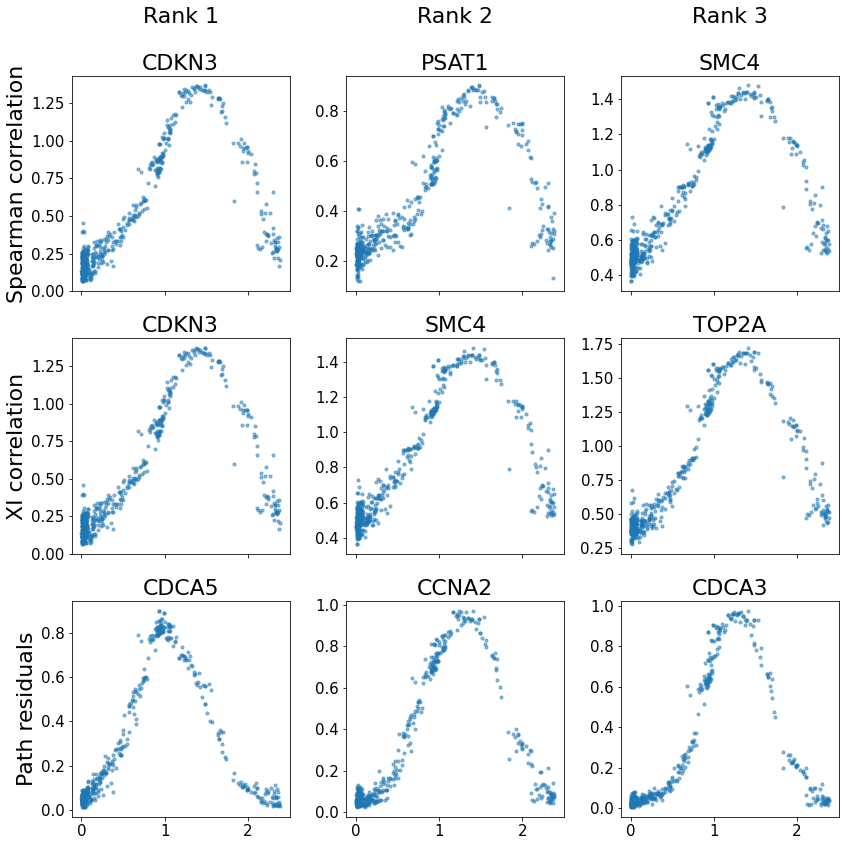

In [10]:
fig, ax = plt.subplots(3,3,figsize=(12,12),sharex=True)

corrs = [corr_spearman, corr_xi, corr_var]
names = ['Spearman correlation', 'XI correlation', 'Path residuals']
for ix,name,corr in zip(range(3),names,corrs):
    for i,c in enumerate(corr.index[:3]):
        _c = _adata.var_names[_adata.var_names==c][0]
        #ax[ix,i].set_title(f'{_c}'+' ('+str(round(corr[c],2))[1:]+')',fontsize=22)
        if i==0: 
            ax[ix,i].set_ylabel(name,fontsize=22)
        if ix==0:
            ax[ix,i].set_title(f'Rank '+str(i+1)+f'\n\n{_c}',fontsize=22)
        else:
            ax[ix,i].set_title(f'{_c}',fontsize=22)
        ax[ix,i].scatter(_adata.obs['epg_pseudotime'],_adata[:,_c].X,s=10,alpha=.5)
plt.tight_layout()
plt.savefig("figures/ewing_top3.png",dpi=300,bbox_inches="tight")
plt.show()

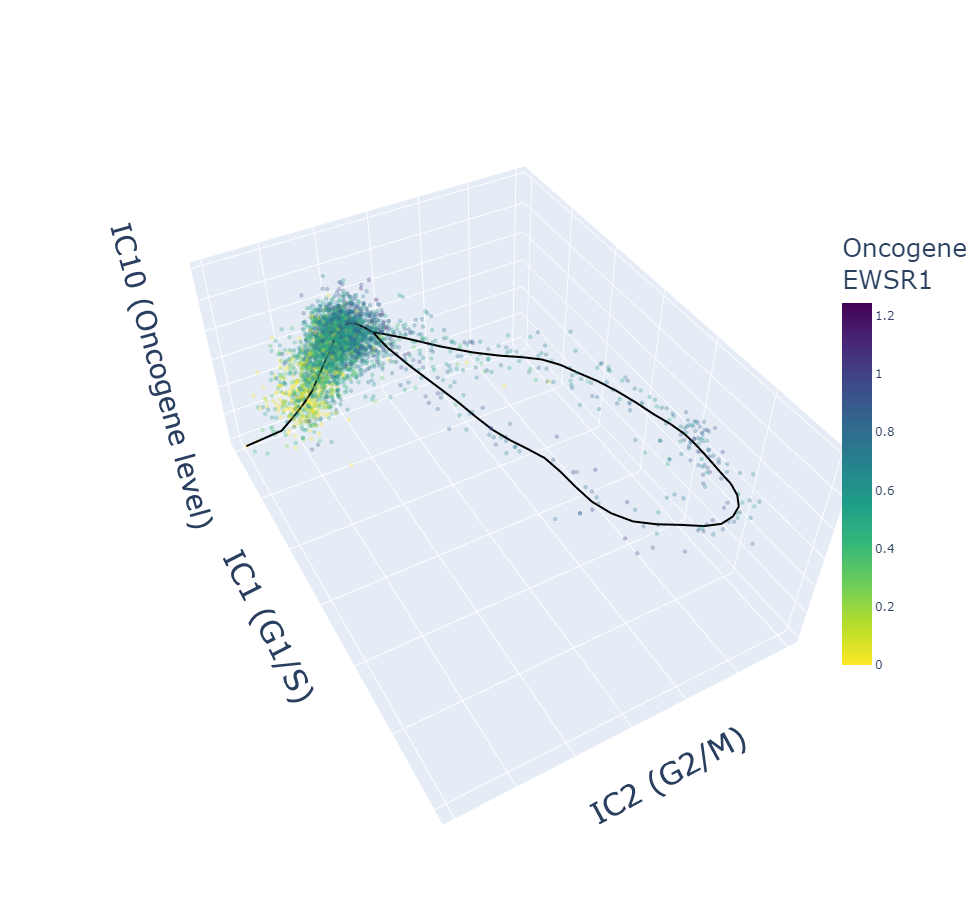

In [13]:
import plotly.express as px
import plotly.graph_objects as go

nodep, edges = adata.uns['epg']['node_pos'], adata.uns['epg']['edge']

alpha=adata.obsm['X_dr'][:,2]
alpha=(alpha-alpha.min())/(alpha.max()-alpha.min())
alpha[alpha<.2]=.2

fig=px.scatter_3d(x=adata.obsm['X_dr'][:,0],y=adata.obsm['X_dr'][:,1],z=adata.obsm['X_dr'][:,2],
                  color=np.array(adata.obs['oncogene']).astype(float),color_continuous_scale='Viridis_r')

fig.update_traces(marker=dict(size=2.5,opacity=.3))


for edge_i in edges:
    curve_i = np.concatenate((nodep[[edge_i[0]]], nodep[[edge_i[1]]]),axis=0).T
    fig.add_trace(go.Scatter3d(x=curve_i[0], 
                               y=curve_i[1], 
                               z=curve_i[2],
                               mode='lines',
                               line=dict(color='black', width=4))
                 )
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.8, y=-1., z=2)
)

fig.update_layout(height=900,width=1100,autosize=False,scene_camera=camera,
                  coloraxis_colorbar_title_text="Oncogene<br>EWSR1",
                  coloraxis_colorbar_len=.5,
                  coloraxis_colorbar_x=.85,
                  coloraxis_colorbar_title_font_size=25,
                  #legend=dict(itemsizing='constant',yanchor="top",y=0.5,xanchor="right",x=.95,font=dict(size=30),bgcolor='rgba(0,0,0,0)'),
                  margin=dict( l=0,r=0, b=0,t=0, pad=0),
                  scene_xaxis_tickvals = np.linspace(np.min(adata.obsm['X_dr'][:,0]),np.max(adata.obsm['X_dr'][:,0]),7), scene_xaxis_ticktext = ['']*7,
                  scene_yaxis_tickvals = np.linspace(np.min(adata.obsm['X_dr'][:,1]),np.max(adata.obsm['X_dr'][:,1]),7), scene_yaxis_ticktext = ['']*7,
                  scene_zaxis_tickvals = np.linspace(np.min(adata.obsm['X_dr'][:,2]),np.max(adata.obsm['X_dr'][:,2]),7), scene_zaxis_ticktext = ['']*7,
                  scene_xaxis_title_text='IC1 (G1/S)',scene_xaxis_title_font_size=30, 
                  scene_yaxis_title_text='IC2 (G2/M)',scene_yaxis_title_font_size=30,
                  scene_zaxis_title_text='IC10 (Oncogene level)',scene_zaxis_title_font_size=28,  
                  #paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')

for trace in fig['data']: 
    if(trace.mode!='markers'): trace['showlegend'] = False
fig.write_image('figures/ewing_3d.png',width=(8.3*.95)*300, height=(11.7/3)*300, scale=1,engine="kaleido")
fig

# Comparison

In [ ]:
from comparison_utils import *
import stream2 as st2
%load_ext rpy2.ipython

def load_slingshot(res_path,slingshot_ncenters):
    %R -i res_path -i slingshot_ncenters
    %R path <- slingshot_ncenters
    curves_gmm = %R readRDS(paste(res_path,'slingshot_curves_gmm.rds',sep='_'))
    curves_kmeans = %R readRDS(paste(res_path,'slingshot_curves_kmeans',path,'.rds',sep='_'))
    cl1 = %R readRDS(paste(res_path,'slingshot_gmm.rds',sep='_'))
    cl2 = %R readRDS(paste(res_path,'slingshot_kmeans',path,'.rds',sep='_'))
    
    all_lineages = {}
    for n,curve in zip(['kmeans','GMM'],[curves_kmeans,curves_gmm]):
        lineages = dict(curve.items())
        for k,v in lineages.items():
            lineages[k] = dict(v.items())
            for k2,v2 in lineages[k].items():
                lineages[k][k2]=np.array(lineages[k][k2])
            lineages[k]['s']=lineages[k]['s'][lineages[k]['ord']-1]
        all_lineages[n]=lineages

    all_lineages['kmeans'] = [v['s'] for k,v in all_lineages['kmeans'].items()]
    all_lineages['GMM'] = [v['s'] for k,v in all_lineages['GMM'].items()]
    return all_lineages

def load_monocle(res_path,mcle_ncenters ,mcle_sigma,mcle_gamma):
    %R -i res_path -i mcle_ncenters -i mcle_sigma -i mcle_gamma
    path = %R path <- paste(mcle_ncenters,mcle_sigma,mcle_gamma,sep='_')
    path=path[0]
    nodep = %R readRDS(paste(res_path,'monocle_dp_mst',path,'.rds',sep='_'))
    nodep = np.array(nodep.T)
    stree = scipy.io.mmread(res_path+f'_monocle_stree_{path}_.mm')
    edges = np.argwhere(np.triu(stree.todense()))
    clus = %R readRDS(paste(res_path,'monocle_clus',path,'.rds',sep='_'))
    partitions = np.array(np.array(clus)[1])
    clusters = np.array(np.array(clus)[2])
    return nodep, stree, edges, partitions, clusters

def run_monocle_slingshot_tuned(data_path, res_path, slingshot_ncenters = 50,mcle_ncenters = 50,mcle_sigma = 0.01,mcle_gamma = 0.5,mcle_eps = 1e-05):
    ! /home/jo/anaconda3/envs/qz_monocle3/bin/Rscript run_monocle_slingshot_tuned.R $data_path $slingshot_ncenters $mcle_ncenters $mcle_sigma $mcle_gamma $mcle_eps $res_path
    
    lineages = load_slingshot(res_path,slingshot_ncenters)
    nodep, stree, edges, partitions, clusters = load_monocle(res_path,mcle_ncenters ,mcle_sigma ,mcle_gamma)
    return lineages, nodep, stree, edges, partitions, clusters

## Default parameter trajectories


Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")

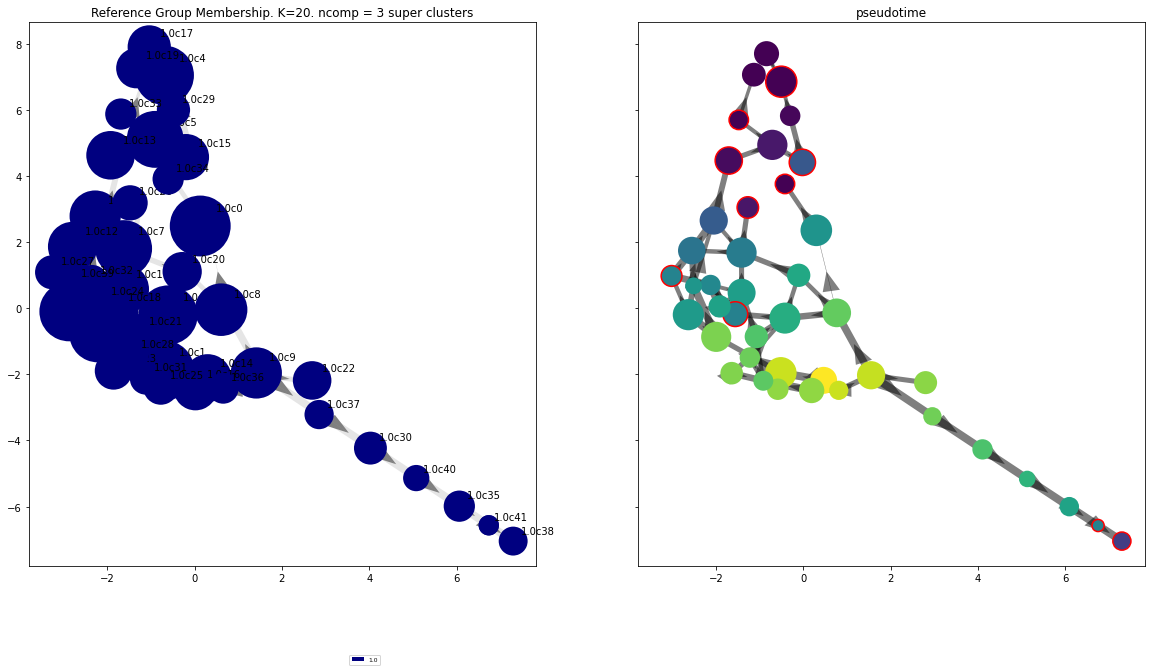

time elapsed 59.9 seconds
input data has shape 3595 (samples) x 3 (features)
time is Thu Oct 28 11:03:02 2021
commencing global pruning
Share of edges kept after Global Pruning 49.83 %
commencing community detection
time is Thu Oct 28 11:03:02 2021
49  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 54.1
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [33, 34, 4, 38, 41, 13, 15, 18, 26, 27]
no sub cluster has majority made of super-cluster  15
terminal clus in this component [33, 18, 9, 36, 42, 1, 26, 17, 38, 43]
final terminal clus [33, 18, 9, 36, 42, 1, 26, 17, 38, 43]
From root 13  to Terminal state 33 is found

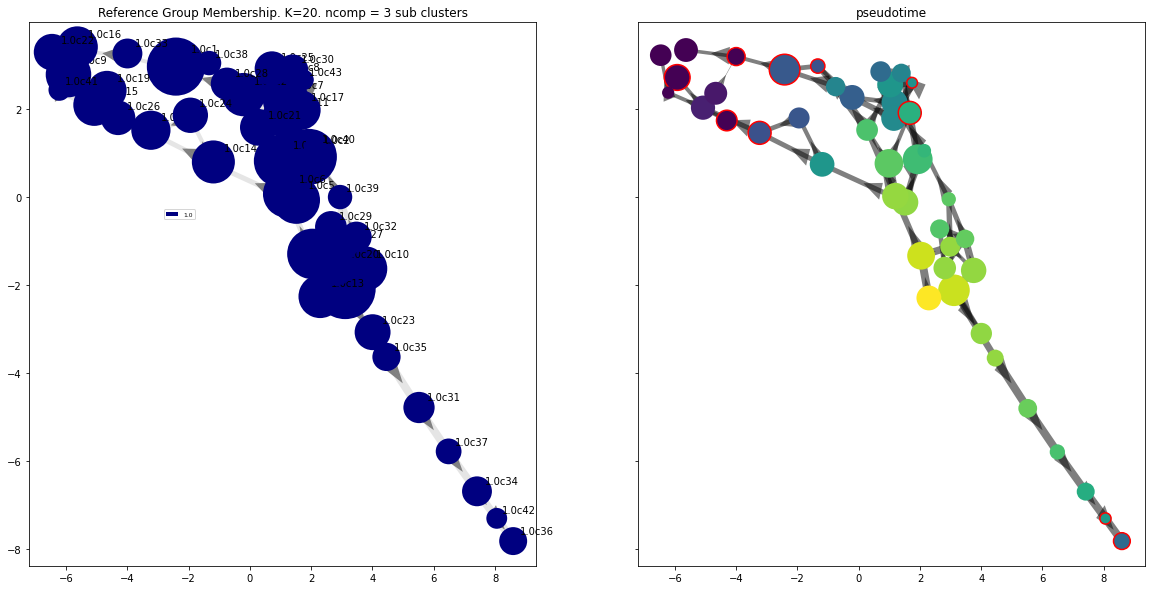

time elapsed 63.4 seconds
dict of terminal state pairs, Super: sub:  {33: 33, 34: 18, 4: 9, 38: 36, 41: 42, 13: 1, 15: 26, 18: 17, 26: 38, 27: 43}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 33
super cluster 13 is a super terminal with sub_terminal cluster 18
super cluster 15 is a super terminal with sub_terminal cluster 9
super cluster 18 is a super terminal with sub_terminal cluster 36
super cluster 26 is a super terminal with sub_terminal cluster 42
super cluster 27 is a super terminal with sub_terminal cluster 1
super cluster 33 is a super terminal with sub_terminal cluster 26
super cluster 34 is a super terminal with sub_terminal cluster 17
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 41 is a super terminal with sub_terminal cluster 43


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 33
super cluster 13 is a super terminal with sub_terminal cluster 18
super cluster 15 is a super terminal with sub_terminal cluster 9
super cluster 18 is a super terminal with sub_terminal cluster 36
super cluster 26 is a super terminal with sub_terminal cluster 42
super cluster 27 is a super terminal with sub_terminal cluster 1
super cluster 33 is a super terminal with sub_terminal cluster 26
super cluster 34 is a super terminal with sub_terminal cluster 17
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 41 is a super terminal with sub_terminal cluster 43


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 33
super cluster 13 is a super terminal with sub_terminal cluster 18
super cluster 15 is a super terminal with sub_terminal cluster 9
super cluster 18 is a super terminal with sub_terminal cluster 36
super cluster 26 is a super terminal with sub_terminal cluster 42
super cluster 27 is a super terminal with sub_terminal cluster 1
super cluster 33 is a super terminal with sub_terminal cluster 26
super cluster 34 is a super terminal with sub_terminal cluster 17
super cluster 38 is a super terminal with sub_terminal cluster 38
super cluster 41 is a super terminal with sub_terminal cluster 43
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:08:32 2021
commencing global pruning
Share of edges kept after Global Pruning 46.36 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visua

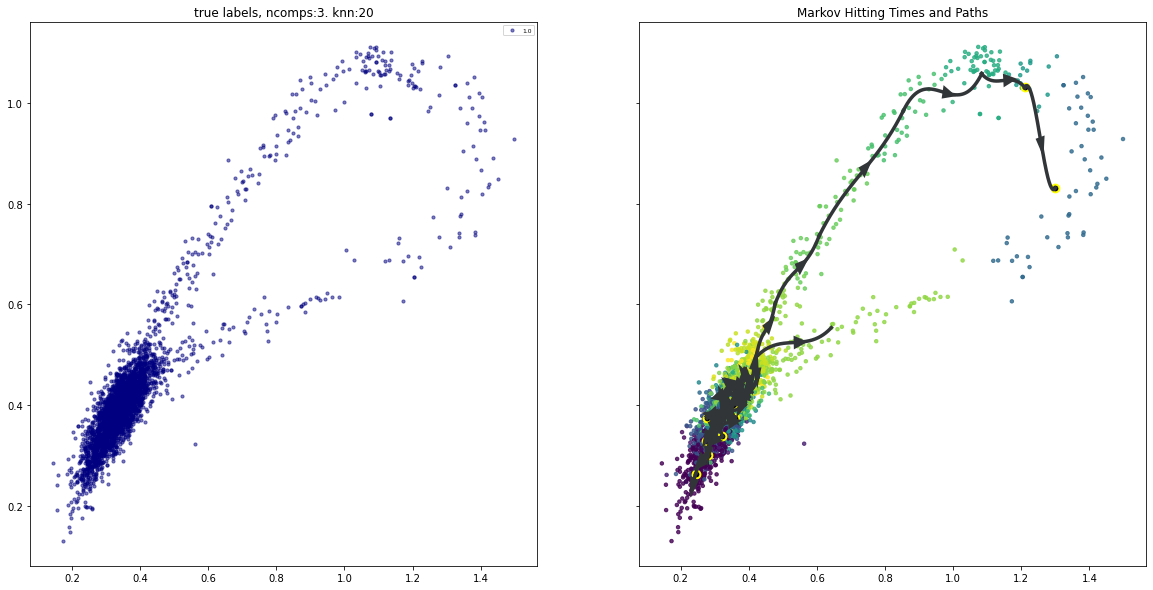

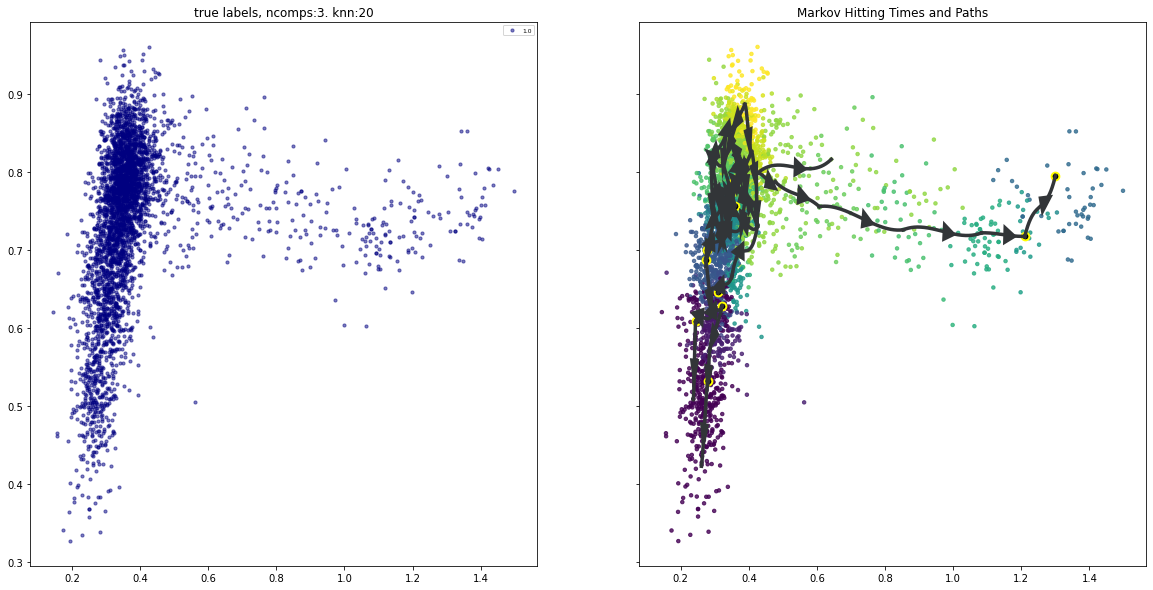

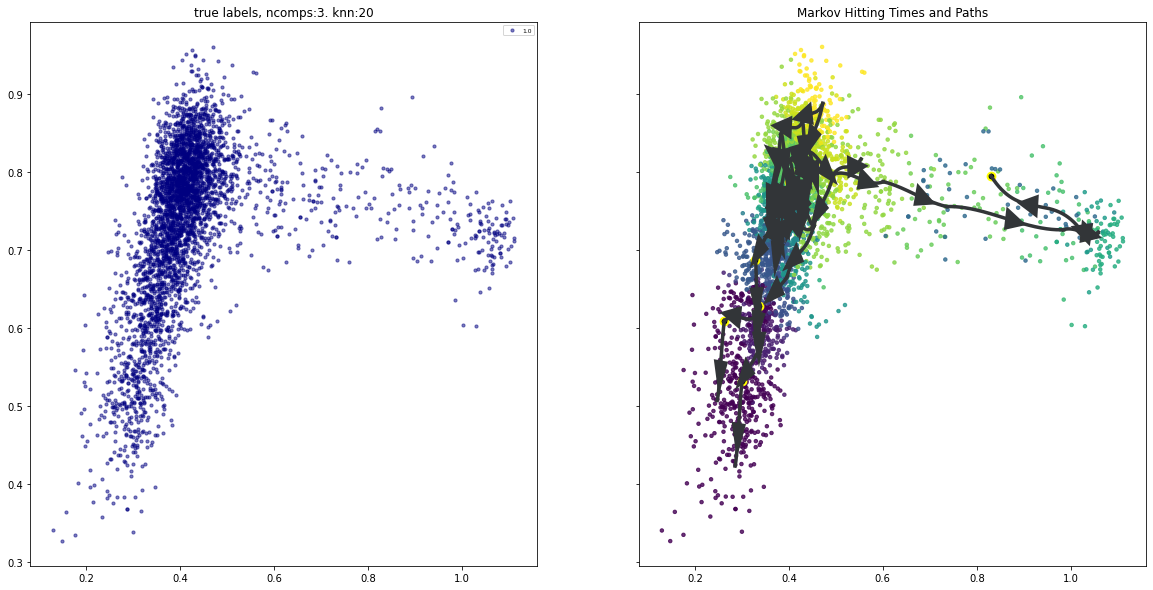

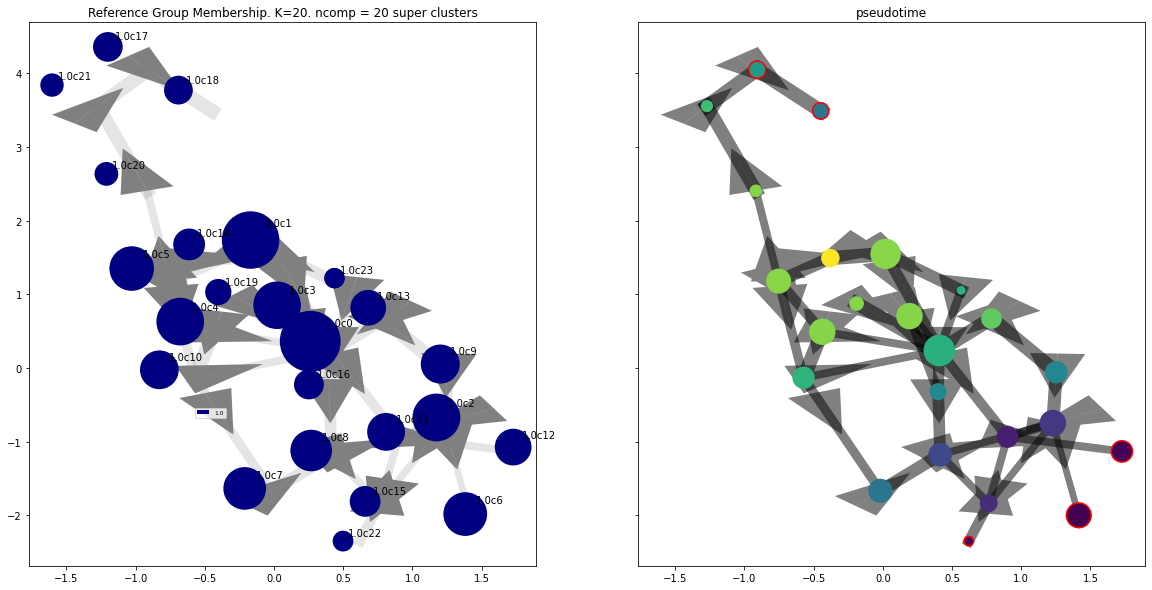

time elapsed 42.2 seconds
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:09:12 2021
commencing global pruning
Share of edges kept after Global Pruning 49.98 %
commencing community detection
time is Thu Oct 28 11:09:12 2021
48  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.0
percentage links trimmed from global pruning relative to start 55.3
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [6, 12, 17, 18, 22]
terminal clus in this component [7, 13, 15, 17, 22]
final terminal clus [7, 13, 15, 17, 22]
From root 0  to Terminal state 7 is found 369  times.
From root 0  to Terminal state 13 is found 73  times.
From root 0  to Terminal state 15 is found 174

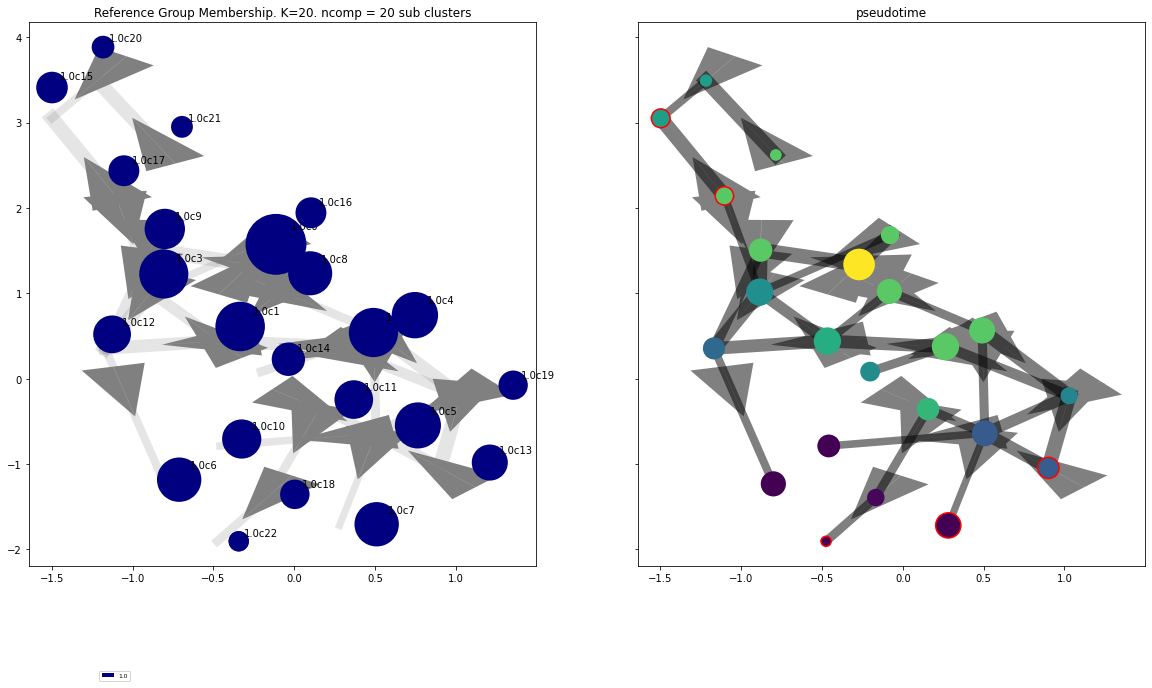

time elapsed 26.0 seconds
dict of terminal state pairs, Super: sub:  {6: 7, 12: 13, 17: 15, 18: 17, 22: 22}


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 12 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 15
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 22 is a super terminal with sub_terminal cluster 22


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 12 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 15
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 22 is a super terminal with sub_terminal cluster 22


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 6 is a super terminal with sub_terminal cluster 7
super cluster 12 is a super terminal with sub_terminal cluster 13
super cluster 17 is a super terminal with sub_terminal cluster 15
super cluster 18 is a super terminal with sub_terminal cluster 17
super cluster 22 is a super terminal with sub_terminal cluster 22
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:12:15 2021
commencing global pruning
Share of edges kept after Global Pruning 47.03 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 
size neighbor array in low-KNN in pca-space for visualization (3595, 6)
commencing community detection
time is Thu Oct 28 11:12:23 2021
125  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.7
percentage l

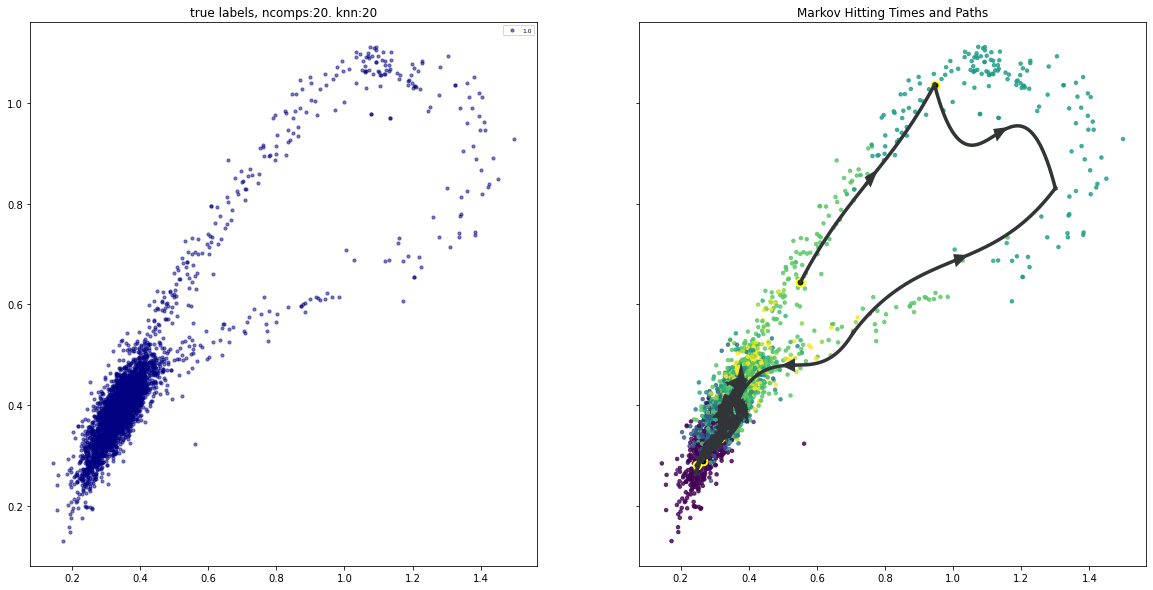

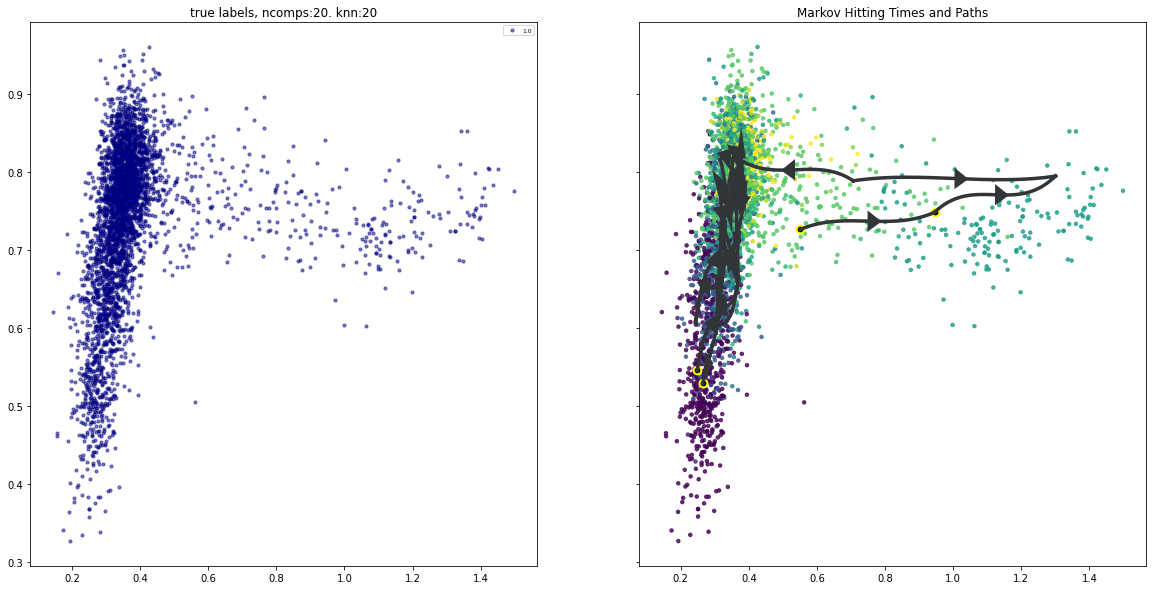

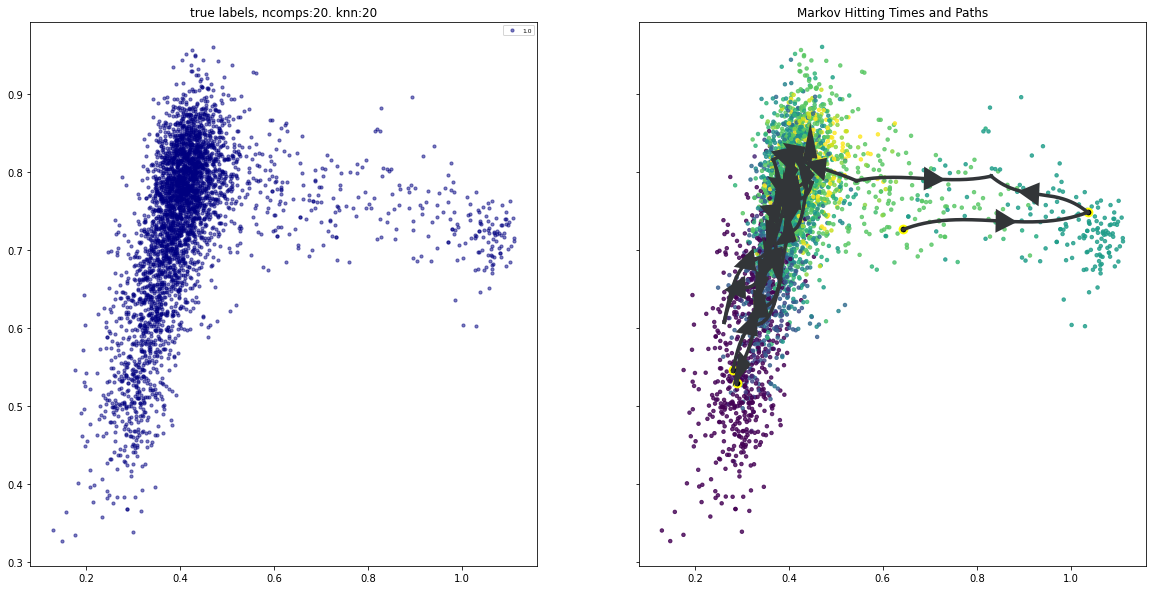

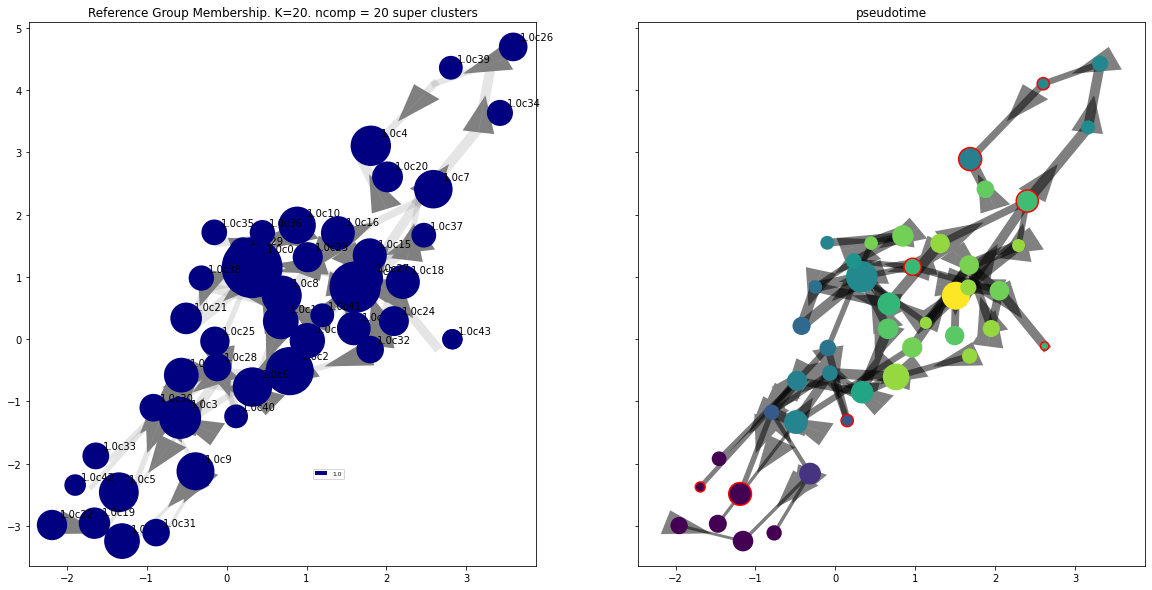

time elapsed 143.4 seconds
input data has shape 3595 (samples) x 20 (features)
time is Thu Oct 28 11:14:35 2021
commencing global pruning
Share of edges kept after Global Pruning 49.93 %
commencing community detection
time is Thu Oct 28 11:14:35 2021
104  clusters before handling small/big
There are 0 clusters that are too big
humanCD34 : global cluster graph pruning level 0.15
number of components before pruning 1
percentage links trimmed from local pruning relative to start 0.1
percentage links trimmed from global pruning relative to start 60.1
there are  1 components in the graph
root user [0]
start computing lazy-teleporting Expected Hitting Times
ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [4, 5, 7, 23, 39, 40, 42, 43]
the sub terminal cluster that best captures the super terminal 23 is 22 but the pseudotime is too low
no sub cluster has majority made of super-cluster  40
no sub cluster has majority made of super-cluster  42
terminal clus in this co

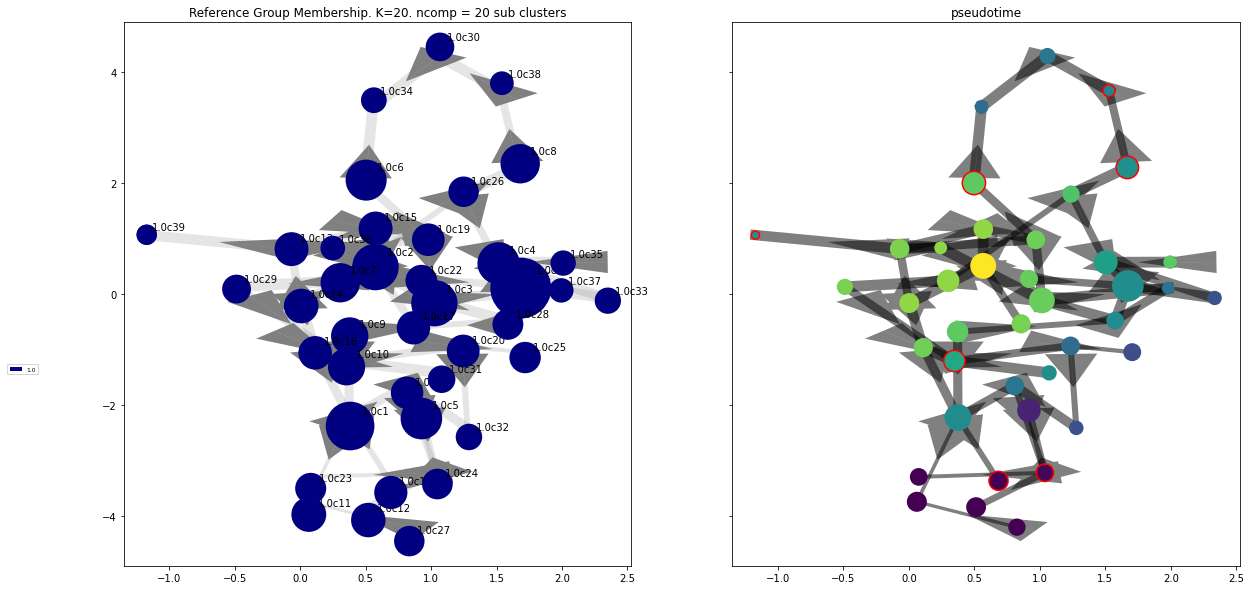

time elapsed 122.4 seconds
dict of terminal state pairs, Super: sub:  {4: 8, 5: 18, 7: 6, 39: 38, 40: 10, 42: 24, 43: 39}


100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 8
super cluster 5 is a super terminal with sub_terminal cluster 18
super cluster 7 is a super terminal with sub_terminal cluster 6
super cluster 39 is a super terminal with sub_terminal cluster 38
super cluster 40 is a super terminal with sub_terminal cluster 10
super cluster 42 is a super terminal with sub_terminal cluster 24
super cluster 43 is a super terminal with sub_terminal cluster 39


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 8
super cluster 5 is a super terminal with sub_terminal cluster 18
super cluster 7 is a super terminal with sub_terminal cluster 6
super cluster 39 is a super terminal with sub_terminal cluster 38
super cluster 40 is a super terminal with sub_terminal cluster 10
super cluster 42 is a super terminal with sub_terminal cluster 24
super cluster 43 is a super terminal with sub_terminal cluster 39


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (11 of 11) |#######################

super cluster 4 is a super terminal with sub_terminal cluster 8
super cluster 5 is a super terminal with sub_terminal cluster 18
super cluster 7 is a super terminal with sub_terminal cluster 6
super cluster 39 is a super terminal with sub_terminal cluster 38
super cluster 40 is a super terminal with sub_terminal cluster 10
super cluster 42 is a super terminal with sub_terminal cluster 24
super cluster 43 is a super terminal with sub_terminal cluster 39


TypeError: run_epg() got an unexpected keyword argument 'incr_n_nodes'

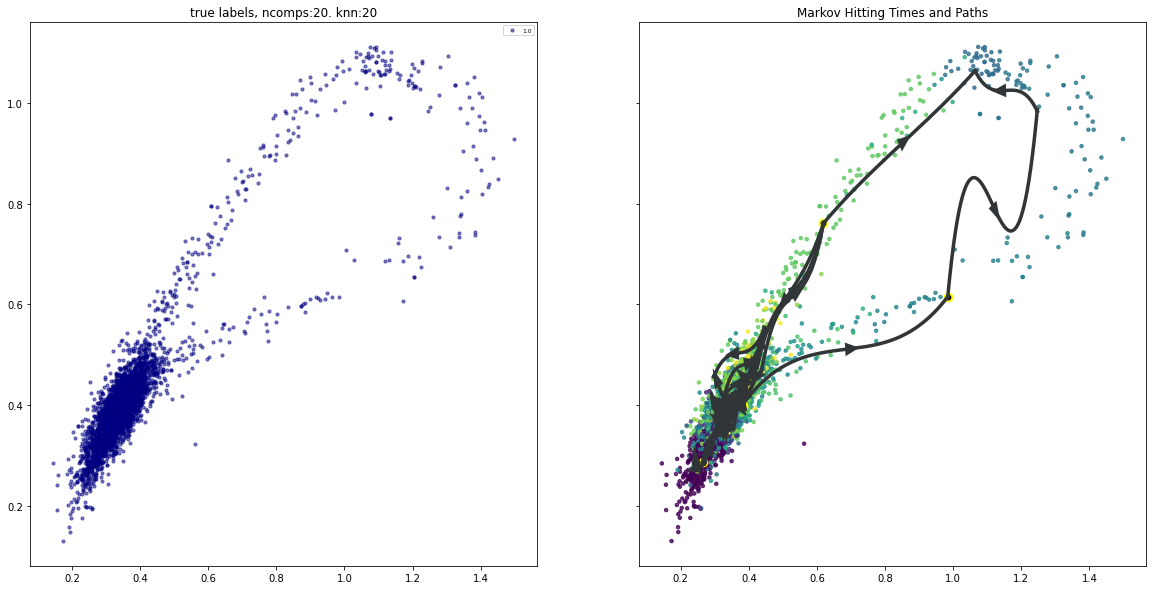

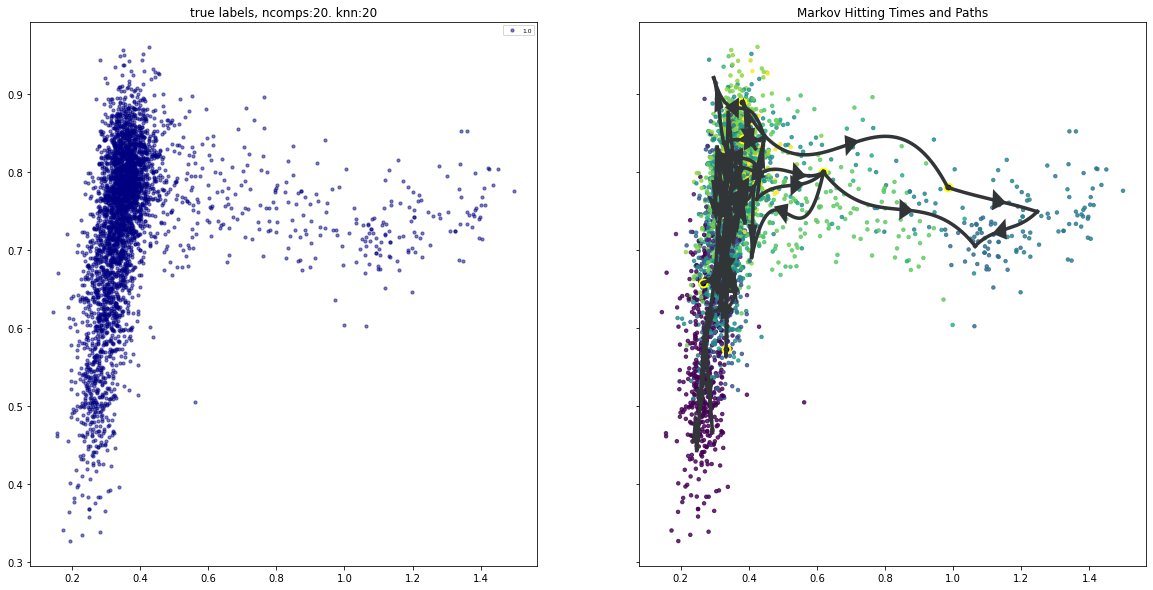

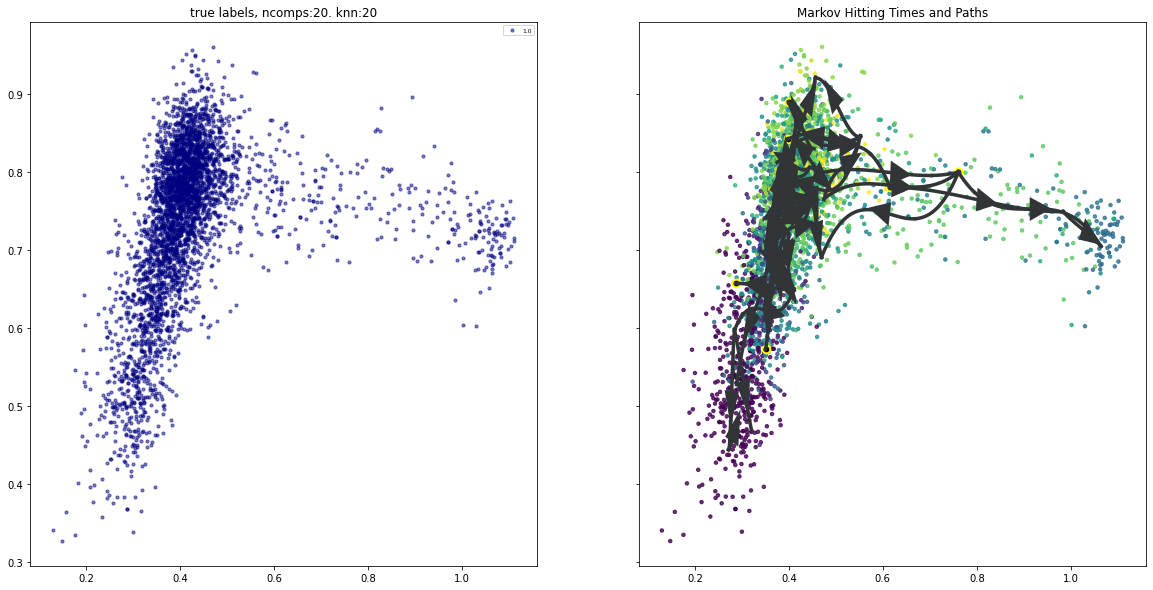

In [3]:
#default results
(slingshot_lineages, 
 mcle_nodep, mcle_stree, mcle_edges, 
 mcle_partitions, mcle_clusters) = run_monocle_slingshot_tuned(data_path, slingshot_ncenters = 50, 
                                                         mcle_ncenters = 50, mcle_sigma = 0.01, 
                                                         mcle_gamma = 0.5, mcle_eps = 1e-05,res_path='R_outputs/ewing/')

((via_out, via_projected_sc_pt, 
 (loci, c_edge, width_edge, pen_color, dot_size)),
 (via_out2, via_projected_sc_pt2,
 (loci2, c_edge2, width_edge2, pen_color2, dot_size2)),
 (via_out3, via_projected_sc_pt3,
 (loci3, c_edge3, width_edge3, pen_color3, dot_size3)),) = run_VIA(X,X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.4 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=3)

((via_out_ica, via_projected_sc_pt_ica, 
 (loci_ica, c_edge_ica, width_edge_ica, pen_color_ica, dot_size_ica)),
 (via_out2_ica, via_projected_sc_pt2_ica,
 (loci2_ica, c_edge2_ica, width_edge2_pca, pen_color2_ica, dot_size2_ica)),
 (via_out3_ica, via_projected_sc_pt3_ica,
 (loci3_ica, c_edge3_ica, width_edge3_ica, pen_color3_ica, dot_size3_ica)),) = run_VIA(_anndata.obsm['X_ica'],X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=20)

((via_out_pca, via_projected_sc_pt_pca, 
 (loci_pca, c_edge_pca, width_edge_pca, pen_color_pca, dot_size_pca)),
 (via_out2_pca, via_projected_sc_pt2_pca,
 (loci2_pca, c_edge2_pca, width_edge2_pca, pen_color2_pca, dot_size2_pca)),
 (via_out3_pca, via_projected_sc_pt3_pca,
 (loci3_pca, c_edge3_pca, width_edge3_pca, pen_color3_pca, dot_size3_pca)),) = run_VIA(_anndata.obsm['X_pca'],X,labels=None,root_user = [0], 
                                                            v0_too_big = 0.3 , v1_too_big = 0.1, v0_random_seed = 42, 
                                                            knn = 20,ncomps=20)

paga_nodep, paga_edges, paga_weights = run_paga(_anndata,X,resolution=1)

NameError: name 'merged_edges' is not defined

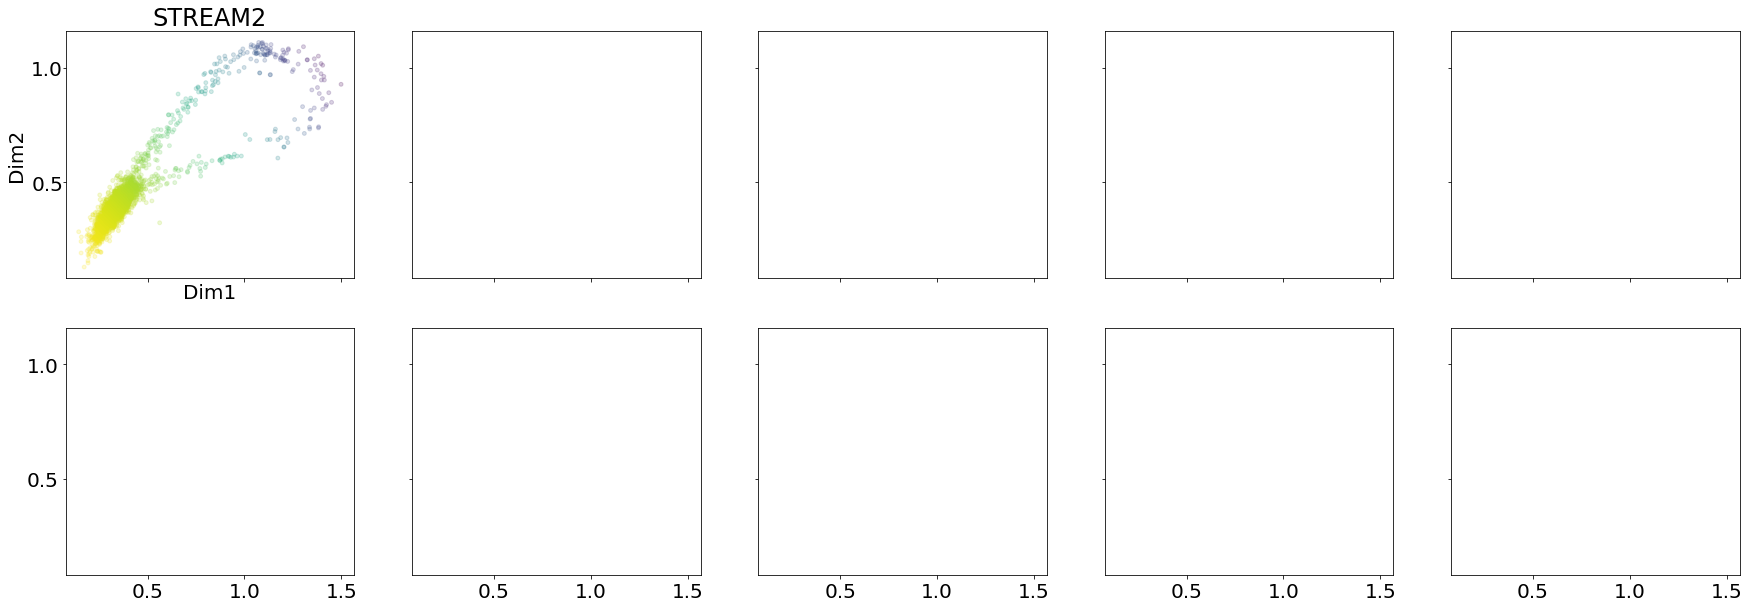

In [4]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2,5,figsize=(30,10),sharey=True,sharex=True)
axs=axs.flat

X_plot=X
c_plot=c
linewidth=2

def init_subplot(d1=0,d2=2):
    ax = next(axs)
    ax.set_xlabel(f'Dim{d1+1}',labelpad=5)
    ax.set_ylabel(f'Dim{d2+1}',labelpad=5)
    ax.locator_params(axis='x',nbins=4)
    ax.locator_params(axis='y',nbins=4)
    ax.tick_params(axis="x",pad=10)
    ax.tick_params(axis="y",pad=-1)
    _=ax.scatter(X_plot[:,d1],X_plot[:,d2],c=c_plot,s=15,alpha=.2,cmap=plt.cm.viridis_r)
    return ax,_

for i0,(d1,d2) in enumerate(((0,1),(1,2))):

    #via
    ax,_=init_subplot(d1,d2)
    if i0==0: 
        ax.set_title('VIA')
        via_plot=via_out_ica
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci_pca, c_edge_ica, width_edge_ica,  pen_color_ica, dot_size_ica)
    else: 
        via_plot=via_out3_ica
        (loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot)=(loci3_ica, c_edge3_ica, width_edge3_ica, pen_color3_ica, dot_size3_ica)
    for i in range(len(via_plot)): 
        ax.plot(via_plot[i][0], via_plot[i][1], linewidth=linewidth, c='#323538')#1.5

        direction_arrow=via_plot[i][2]; head_width=via_plot[i][3]
        if direction_arrow == 1:
            ax.arrow(via_plot[i][4], via_plot[i][5], via_plot[i][6], via_plot[i][7], shape='full', lw=0, length_includes_head=False,
                      head_width=.03, color='#323538')  
    count_ = 0
    for i, c_e, w, pc, dsz in zip(loci_plot, c_edge_plot, width_edge_plot, pen_color_plot, dot_size_plot):  # sc_supercluster_nn
        ax.scatter(X[i, d1], X[i, d2], c='black', s=dsz, edgecolors=c_e, linewidth=w)
        count_ = count_ + 1

    #monocle
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Monocle3')
    for e in mcle_edges:
        curve_i = np.concatenate((mcle_nodep[[e[0]]], mcle_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #slingshot
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('Slingshot')
    for l in slingshot_lineages['GMM']:
        curve_i = l.T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)

    #paga
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('PAGA')
    for e,w in zip(paga_edges,paga_weights):
        curve_i = np.concatenate((paga_nodep[[e[0]]], paga_nodep[[e[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=2*linewidth*w)

    #epg
    ax,_=init_subplot(d1,d2)
    if i0==0: ax.set_title('STREAM2')
    for edge_i in edges:
        curve_i = np.concatenate((nodep[[edge_i[0]]], nodep[[edge_i[1]]]),axis=0).T
        ax.plot(curve_i[d1], curve_i[d2], c='k',linewidth=linewidth)


fig.tight_layout()
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar=fig.colorbar(_, cax=cbar_ax)
cbar.set_label('Cell cycle score', rotation=270,labelpad=30)
cbar.set_alpha(1)
cbar.draw_all()
plt.savefig('figures/ewing_default_2d.png',dpi=300,bbox_inches='tight')